In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
invoice=pd.read_csv("Invoice_Export.csv")
modality=pd.read_csv("Modality.csv")
modality_pl=pd.read_csv("Mod_PL.csv")

## Merging the files
- About the data, only 57 Modality description available

In [3]:
mod_data=pd.merge(modality,modality_pl,left_on='PSI_MODALITY',right_on='Modality',how="left")
invoice_data=pd.merge(invoice,mod_data,on='PSI_CODE',how="left")

In [4]:
invoice_data.shape

(28064, 16)

## Check the data quality given to us

In [5]:
invoice_data.isna().sum()/invoice_data.shape[0]*100

CUSTOMER_NUMBER         0.000000
CUSTOMER_NAME           0.000000
SALES_ORDER             0.000000
FUL_SET                 0.000000
PSI_CODE                0.000000
INV_NUMBER              0.000000
INV_DATE                0.000000
DUE_DATE                0.000000
ACTUAL_DATE_CLOSED      0.000000
AMOUNT_DUE_ORIGINAL     0.000000
PSI_CODE_DESCRIPTION    0.003563
PSI_MODALITY            0.003563
MOD_DESCRIPTION         0.003563
Modality                0.142531
DESCRIPTION             0.142531
HC_PRODUCT_PANDL        0.142531
dtype: float64

## Unique values in the data

In [6]:
invoice_data.nunique()

CUSTOMER_NUMBER          3068
CUSTOMER_NAME            2918
SALES_ORDER             15862
FUL_SET                    54
PSI_CODE                  538
INV_NUMBER              28050
INV_DATE                  910
DUE_DATE                 1070
ACTUAL_DATE_CLOSED        880
AMOUNT_DUE_ORIGINAL     21943
PSI_CODE_DESCRIPTION      534
PSI_MODALITY               23
MOD_DESCRIPTION            23
Modality                   22
DESCRIPTION                22
HC_PRODUCT_PANDL            3
dtype: int64

- Total Customers : 3068
- 2 years of invoice data : 01-APR-15 To 31-OCT-17
- Total Invoice generated : 28050
- Amt. of Total Invoive : 4112977868.59
- About 66% invoices gets cleared on or before time

In [7]:
col_to_dates=("INV_DATE",'DUE_DATE','ACTUAL_DATE_CLOSED')
for i in col_to_dates:
    invoice_data[i]=pd.to_datetime(invoice_data[i])

In [8]:
invoice_data["inv_month"]=invoice_data.INV_DATE.dt.month
invoice_data["due_month"]=invoice_data.DUE_DATE.dt.month
invoice_data["inv_week"]=invoice_data.INV_DATE.dt.weekofyear
invoice_data["due_week"]=invoice_data.DUE_DATE.dt.weekofyear

In [9]:
invoice_data.dtypes

CUSTOMER_NUMBER                  int64
CUSTOMER_NAME                   object
SALES_ORDER                      int64
FUL_SET                          int64
PSI_CODE                        object
INV_NUMBER                       int64
INV_DATE                datetime64[ns]
DUE_DATE                datetime64[ns]
ACTUAL_DATE_CLOSED      datetime64[ns]
AMOUNT_DUE_ORIGINAL            float64
PSI_CODE_DESCRIPTION            object
PSI_MODALITY                   float64
MOD_DESCRIPTION                 object
Modality                       float64
DESCRIPTION                     object
HC_PRODUCT_PANDL                object
inv_month                        int64
due_month                        int64
inv_week                         int64
due_week                         int64
dtype: object

In [10]:
invoice_data["DaysDelay"]=(invoice_data.ACTUAL_DATE_CLOSED-invoice_data.DUE_DATE).dt.days
invoice_data["MonthsGap"]=invoice_data.DUE_DATE.dt.month-invoice_data.INV_DATE.dt.month
invoice_data["DaysGap"]=invoice_data.DUE_DATE.dt.weekofyear-invoice_data.INV_DATE.dt.weekofyear
invoice_data.DaysDelay.describe()

count    28064.000000
mean        26.877815
std         75.648622
min      -1105.000000
25%         -4.000000
50%          7.000000
75%         32.000000
max        959.000000
Name: DaysDelay, dtype: float64

In [11]:
invoice_data.head(5)

,CUSTOMER_NUMBER,CUSTOMER_NAME,SALES_ORDER,FUL_SET,PSI_CODE,INV_NUMBER,INV_DATE,DUE_DATE,ACTUAL_DATE_CLOSED,AMOUNT_DUE_ORIGINAL,...,Modality,DESCRIPTION,HC_PRODUCT_PANDL,inv_month,due_month,inv_week,due_week,DaysDelay,MonthsGap,DaysGap
0,202214,BAPTIST HEALTH MADISONVILLE INC,4412511,1,NUCOTH,500680555,2016-06-24,2016-07-24,2016-08-23,700.00,...,410.0,Nuclear,DI,6,7,25,29,30,1,4
1,301049,PENN STATE MILTON S HERSHEY MEDICAL CENTER,4272690,1,XMM561,500624193,2015-04-23,2015-05-23,2015-09-15,28855.28,...,140.0,GDXR Mammo,DI,4,5,17,21,115,1,4
2,1268541,UNIVERSITY OF WISCONSIN MADISON,4376780,11,CTOTH,500681627,2016-07-06,2016-08-05,2016-10-20,9000.00,...,210.0,CT,DI,7,8,27,31,76,1,4
3,154929,WHEATON FRANCISCAN HEALTHCARE,4410814,1,CTOTH,500681632,2016-07-06,2016-08-05,2016-08-05,400.00,...,210.0,CT,DI,7,8,27,31,0,1,4
4,409033,"GE HFS, LLC",4451250,1,PTCO20,500705919,2017-09-28,2017-12-27,2017-09-30,2622000.01,...,810.0,PET,DI,9,12,39,52,-88,3,13


In [12]:
def due_payment_flag(x):
    if(x==0):
        return 'On time'
    elif(x<0):
        return 'Before Time'
    else:
        return 'After Time'
def late_payment(x):
    if(x>0):
        return 1
    else:
        return 0
invoice_data['due_payment_flag'] = invoice_data.DaysDelay.apply(due_payment_flag)
invoice_data['late_payment_flag'] = invoice_data.DaysDelay.apply(late_payment)
print 100*invoice_data.due_payment_flag.value_counts()/28064

After Time     66.326967
Before Time    31.688284
On time         1.984749
Name: due_payment_flag, dtype: float64


Lets see how many invoices were cleared on time/and how many after due date

In [13]:
data=invoice_data.groupby("due_payment_flag")
data=data.agg({"INV_NUMBER":'count'})
data.head()

,INV_NUMBER
due_payment_flag,
After Time,18614
Before Time,8893
On time,557


/Users/sowmiyanmorri/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


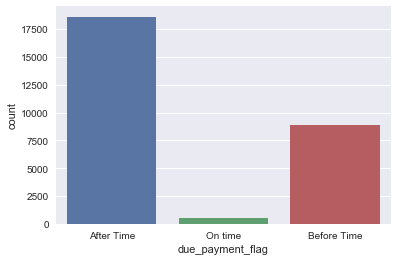

In [14]:
sns.countplot(x='due_payment_flag',data = invoice_data)

Lets see what is the value of dollars coming after due date

In [15]:
data=invoice_data.groupby("due_payment_flag")
data=data.agg({"AMOUNT_DUE_ORIGINAL":'mean'})
data.head()

,AMOUNT_DUE_ORIGINAL
due_payment_flag,
After Time,128901.458217
Before Time,183461.162999
On time,147371.638743


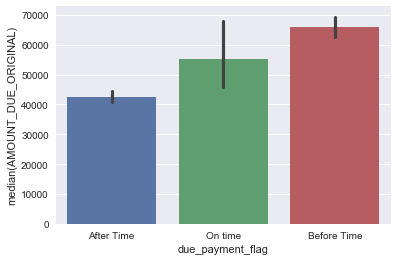

In [16]:
sns.barplot(x= 'due_payment_flag',y = 'AMOUNT_DUE_ORIGINAL', data = invoice_data , estimator= np.median)

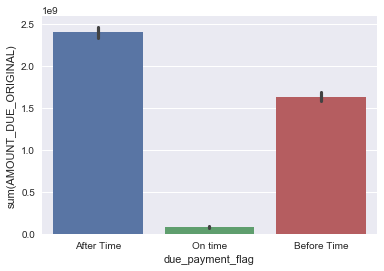

In [17]:
sns.barplot(x= 'due_payment_flag',y = 'AMOUNT_DUE_ORIGINAL', data = invoice_data , estimator= np.sum)

Lets see distribution of how many customer are on time

In [18]:
customer_analysis=pd.DataFrame(pd.crosstab(invoice_data.CUSTOMER_NAME, invoice_data.due_payment_flag))
customer_analysis["Customer"]=customer_analysis.index
customer_analysis=customer_analysis.reset_index(drop=True)
customer_analysis=customer_analysis[['Customer',"After Time","Before Time","On time"]]
del customer_analysis.index.name
customer_analysis["AlwaysLate"]=np.where((customer_analysis["Before Time"]==0)&(customer_analysis["On time"]==0),"Late","Sometimeslate")


data=invoice_data.groupby("CUSTOMER_NAME")
data=pd.DataFrame(data.agg({"AMOUNT_DUE_ORIGINAL":'sum'}))
data["Customer"]=data.index


customer_analysis=pd.merge(customer_analysis,data,on="Customer",how="left")

In [19]:
customer_analysis.AlwaysLate.value_counts()/customer_analysis.shape[0]*100

Sometimeslate    59.527073
Late             40.472927
Name: AlwaysLate, dtype: float64

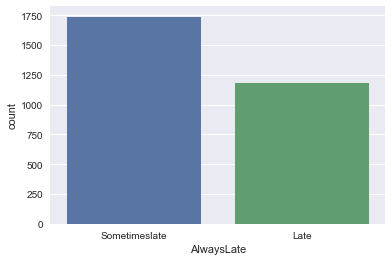

In [20]:
sns.countplot(x='AlwaysLate',data = customer_analysis)

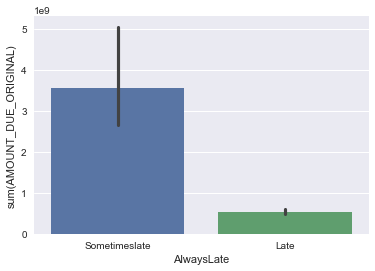

In [21]:
sns.barplot(x= 'AlwaysLate',y = 'AMOUNT_DUE_ORIGINAL', data = customer_analysis , estimator= np.sum)

In [22]:
data=customer_analysis.groupby("AlwaysLate")
data=pd.DataFrame(data.agg({"AMOUNT_DUE_ORIGINAL":'sum'}))
data["Late"]=data.index
data=data[["Late","AMOUNT_DUE_ORIGINAL"]]
data["Percent"]=data.AMOUNT_DUE_ORIGINAL/data.AMOUNT_DUE_ORIGINAL.sum()
print data.AMOUNT_DUE_ORIGINAL.sum()
data

4112977868.59


,Late,AMOUNT_DUE_ORIGINAL,Percent
AlwaysLate,,,
Late,Late,5.428868e+08,0.131994
Sometimeslate,Sometimeslate,3.570091e+09,0.868006


In [23]:
invoice_data.AMOUNT_DUE_ORIGINAL[invoice_data.CUSTOMER_NAME.isin(customer_analysis.Customer[customer_analysis.AlwaysLate=="Late"])].sum()/invoice_data.AMOUNT_DUE_ORIGINAL.sum()*100

13.199360001567694

Lets see distribution of modality wise delay pattern

In [24]:
data=invoice_data.groupby('DESCRIPTION')
data=data.agg({"DaysDelay":'mean'})
data.head()

,DaysDelay
DESCRIPTION,
A and S,37.952419
AW,33.540299
CIS Periop,41.000000
CT,19.340635
CVIS,62.514905


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

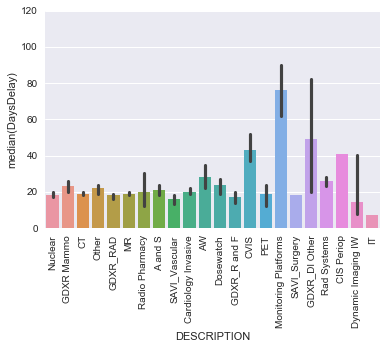

In [25]:
sns.plt.ylim(0, 120)
sns.plt.xlim(0, 500000000000)
sns.barplot(x= 'DESCRIPTION',y = 'DaysDelay', data = invoice_data[invoice_data.DaysDelay>=0] , estimator= np.median)
import matplotlib.pylab as plt 
plt.xticks(rotation=90)


Amount vs Days Delayed Chart

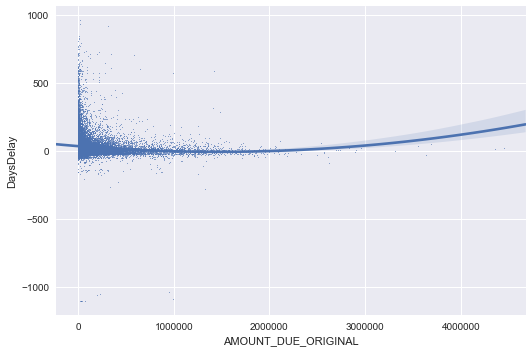

In [26]:
sns.lmplot(x= 'AMOUNT_DUE_ORIGINAL',y = 'DaysDelay',data = invoice_data,fit_reg=True,order=2,aspect=1.5,scatter_kws={"s": 1},)

FUL_ST has 53 unique values

Relationship of this with Days Delay


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

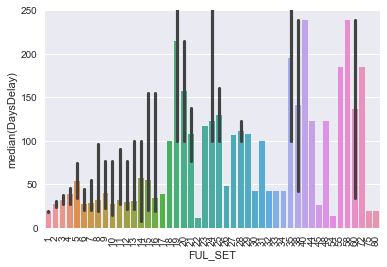

In [27]:
sns.plt.ylim(0, 250)
sns.plt.xlim(0, 500000000000)
sns.barplot(x= 'FUL_SET',y = 'DaysDelay', data = invoice_data[invoice_data.DaysDelay>=0] , estimator= np.median)
import matplotlib.pylab as plt 
plt.xticks(rotation=90)

In [28]:
agg_values = {'late_payment_flag': np.mean,'AMOUNT_DUE_ORIGINAL':np.sum,'DaysDelay':np.mean}
cust_Details = invoice_data.groupby(['CUSTOMER_NAME']).agg(agg_values).reset_index()
cust_Details.columns =  ['CUSTOMER_NAME','Tot_Amt','LP_Rate','Avg_Delays']
cust_Details['percentage_Tot_Amt'] = 100*cust_Details.Tot_Amt / sum(cust_Details.Tot_Amt)
cust_Details.sort_values(by='percentage_Tot_Amt',ascending=False,inplace=True)
cust_Details.head()

,CUSTOMER_NAME,Tot_Amt,LP_Rate,Avg_Delays,percentage_Tot_Amt
910,"GE HFS, LLC",5.896799e+08,0.049498,-18.701578,14.337054
2742,VA CHIEF FISCAL DIVISION 901A,1.839103e+08,0.346260,-5.156510,4.471464
111,ASCENSION HEALTH MINISTRY SERVICE CENTER LLC,4.711951e+07,0.635838,13.624277,1.145630
1479,MAYO CLINIC,3.589170e+07,0.823308,19.345865,0.872645
1566,MERCY HEALTH,3.418963e+07,0.594249,16.722045,0.831262


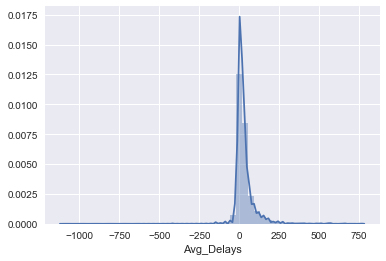

In [29]:
##Distribution by Average Delays

sns.distplot(cust_Details.Avg_Delays) ## Custumer Distrubution by Sales Vol

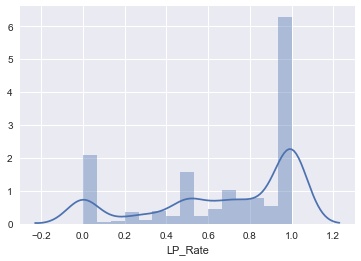

In [30]:
##Distribution by LP_Rate

sns.distplot(cust_Details.LP_Rate)

In [31]:
cust_Details.sort_values(by='LP_Rate',inplace=True,ascending=False)
print cust_Details[cust_Details.LP_Rate==1].shape
print cust_Details[cust_Details.LP_Rate==1].percentage_Tot_Amt.sum()

(1181, 5)
13.1993600016


In [32]:
PSI_LP_Rate = invoice_data.groupby(['PSI_CODE']).agg({'late_payment_flag':np.mean}).reset_index()
PSI_LP_Rate.columns = ['PSI_CODE','PSI_LPR']

In [33]:
## Modelling exercise
# Predict due date for a customer

In [34]:
invoice_data = pd.merge(invoice_data,cust_Details[['CUSTOMER_NAME','LP_Rate','Avg_Delays']],how='left',on='CUSTOMER_NAME')
invoice_data = pd.merge(invoice_data,PSI_LP_Rate[['PSI_CODE','PSI_LPR']],how='left',on='PSI_CODE')

In [35]:
invoice_data.head()

,CUSTOMER_NUMBER,CUSTOMER_NAME,SALES_ORDER,FUL_SET,PSI_CODE,INV_NUMBER,INV_DATE,DUE_DATE,ACTUAL_DATE_CLOSED,AMOUNT_DUE_ORIGINAL,...,inv_week,due_week,DaysDelay,MonthsGap,DaysGap,due_payment_flag,late_payment_flag,LP_Rate,Avg_Delays,PSI_LPR
0,202214,BAPTIST HEALTH MADISONVILLE INC,4412511,1,NUCOTH,500680555,2016-06-24,2016-07-24,2016-08-23,700.00,...,25,29,30,1,4,After Time,1,1.000000,30.500000,0.707260
1,301049,PENN STATE MILTON S HERSHEY MEDICAL CENTER,4272690,1,XMM561,500624193,2015-04-23,2015-05-23,2015-09-15,28855.28,...,17,21,115,1,4,After Time,1,1.000000,65.272727,0.673152
2,1268541,UNIVERSITY OF WISCONSIN MADISON,4376780,11,CTOTH,500681627,2016-07-06,2016-08-05,2016-10-20,9000.00,...,27,31,76,1,4,After Time,1,0.764706,31.911765,0.755006
3,154929,WHEATON FRANCISCAN HEALTHCARE,4410814,1,CTOTH,500681632,2016-07-06,2016-08-05,2016-08-05,400.00,...,27,31,0,1,4,On time,0,0.916667,26.375000,0.755006
4,409033,"GE HFS, LLC",4451250,1,PTCO20,500705919,2017-09-28,2017-12-27,2017-09-30,2622000.01,...,39,52,-88,3,13,Before Time,0,0.049498,-18.701578,0.428571


In [36]:
invoice_data.columns

Index([u'CUSTOMER_NUMBER', u'CUSTOMER_NAME', u'SALES_ORDER', u'FUL_SET',
       u'PSI_CODE', u'INV_NUMBER', u'INV_DATE', u'DUE_DATE',
       u'ACTUAL_DATE_CLOSED', u'AMOUNT_DUE_ORIGINAL', u'PSI_CODE_DESCRIPTION',
       u'PSI_MODALITY', u'MOD_DESCRIPTION', u'Modality', u'DESCRIPTION',
       u'HC_PRODUCT_PANDL', u'inv_month', u'due_month', u'inv_week',
       u'due_week', u'DaysDelay', u'MonthsGap', u'DaysGap',
       u'due_payment_flag', u'late_payment_flag', u'LP_Rate', u'Avg_Delays',
       u'PSI_LPR'],
      dtype='object')

In [37]:
data=invoice_data[['AMOUNT_DUE_ORIGINAL','LP_Rate','MonthsGap','DaysGap',"Avg_Delays",'inv_month', 'due_month', 'inv_week',
       'due_week','PSI_LPR','PSI_CODE_DESCRIPTION','CUSTOMER_NAME','FUL_SET','DESCRIPTION']]

In [38]:
import xgboost as xgb
#Features = ['AMOUNT_DUE_ORIGINAL','LP_Rate','PSI_LPR','PSI_MODALITY','CUSTOMER_NAME','FUL_SET','DESCRIPTION']
col=['PSI_CODE_DESCRIPTION','CUSTOMER_NAME','DESCRIPTION']
for i in col:
    data[i]=data[i].astype('object')
    
from sklearn import model_selection, preprocessing

# for f in invoice_data.columns:
#     if invoice_data[f].dtype=='object':
#         print(f)
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(invoice_data[f].values.astype('str')))
#         invoice_data[f] = lbl.transform(list(invoice_data[f].values.astype('str')))
        
for column in col:
    temp = pd.get_dummies(pd.Series(data[column]))
    data = pd.concat([data,temp],axis=1)
    data = data.drop([column],axis=1)

X = data
y = invoice_data.DaysDelay

import xgboost as xgb
d_train = xgb.DMatrix(X, label=y)
params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.01
params['max_depth'] = 3
params["subsample"] = 0.7
params["colsample_bytree"] = 0.3

model = xgb.cv(dtrain=d_train,nfold=2,params=params,num_boost_round=10,verbose_eval=True)

/Users/sowmiyanmorri/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


[0]	train-rmse:79.9972+1.35733	test-rmse:79.9968+1.36485
[1]	train-rmse:79.8576+1.32529	test-rmse:79.8667+1.39417
[2]	train-rmse:79.7492+1.32695	test-rmse:79.762+1.39677
[3]	train-rmse:79.5318+1.39419	test-rmse:79.5654+1.3494
[4]	train-rmse:79.4184+1.39214	test-rmse:79.462+1.35567
[5]	train-rmse:79.3206+1.38104	test-rmse:79.3683+1.36755
[6]	train-rmse:79.0522+1.39174	test-rmse:79.1099+1.38343
[7]	train-rmse:78.8727+1.46421	test-rmse:78.9422+1.32738
[8]	train-rmse:78.7581+1.46701	test-rmse:78.8452+1.31987
[9]	train-rmse:78.6682+1.4766	test-rmse:78.7647+1.31424


In [39]:
bst_model = xgb.train(dtrain=d_train,params=params,num_boost_round=500,verbose_eval=True)

In [40]:
xgb_ttrain_x = xgb.DMatrix(X)
predicted_Days_Delayed = bst_model.predict(xgb_ttrain_x,ntree_limit=bst_model.best_ntree_limit)
invoice_data['predicted_Days_Delayed'] = predicted_Days_Delayed
invoice_data['error'] = abs(invoice_data.DaysDelay-invoice_data.predicted_Days_Delayed)

In [41]:
invoice_data.error.mean()

32.54623794555664

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, tree, linear_model
from sklearn.cross_validation import train_test_split
X = data.values
y = invoice_data.DaysDelay.values

print X.shape
print y.shape

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.3,random_state=0)
rf = rf =  RandomForestRegressor(n_estimators=100, max_features = 'auto', min_samples_leaf = 50, max_depth = 5, oob_score = True, random_state = 2017)

rf.fit(X_train, y_train)



/Users/sowmiyanmorri/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(28064, 3485)
(28064,)
#############Validation-set###############


NameError: name 'math' is not defined

In [43]:
import math
print ('#############Validation-set###############')
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((rf.predict(X_test) - y_test) ** 2)))
pred_test=rf.predict(X)
print ('#############Test-set###############')
print("RMSE: %.2f"
      % math.sqrt(np.mean((rf.predict(X) - invoice_data.DaysDelay) ** 2)))



#############Validation-set###############
RMSE: 60.37
#############Test-set###############
RMSE: 64.26


In [ ]:
invoice_data.head(10)

In [ ]:
def importance_XGB(model):
    impdf = []
    for ft, score in model.get_fscore().iteritems():
        impdf.append({'feature': ft, 'importance': score})
    impdf = pd.DataFrame(impdf)
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    return impdf
    
    importance_XGB(model)

In [ ]:
all_features=importance_XGB(bst_model)
all_features.head(10)

In [ ]:
sns.kdeplot(invoice_data.predicted_Days_Delayed,bw=.2, label="Predicted Delays")
sns.kdeplot(invoice_data.DaysDelay, bw=.2, label="Original Delays")
plt.legend();